# Analyze sound pilot recordings

In [76]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import scipy.stats as st
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import time

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib notebook

In [3]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\625820_06222022\2022-06-22_14-25-10\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\625821_07112022\2022-07-11_14-42-15\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\625821_07122022\2022-07-12_13-51-39\processed",
]


In [135]:
sel_session=2
session=Session(path=main_path[sel_session])

In [136]:
session.trials

,Unnamed: 0,trialStartFrame,trialEndFrame,trialStimID,trialStimStartFrame,trialVisStimFrames,trialGratingOri,trialGratingPhase,trialVisStimContrast,trialSoundAM,trialSoundDur,trialSoundFreq_0,trialSoundFreq_1,trialSoundType,trialSoundVolume,stimStartTime,stimLatency,trial_stim_dur
0,0,0,644,sound4,404,0,0.0,0.0,0,NaN,0.5,10000.0,6000.0,linear sweep,1,22.550002,0.008542,0.5
1,1,645,992,vis1,752,30,0.0,0.5,1,NaN,0.0,NaN,NaN,NaN,0,28.367140,0.020390,0.5
2,2,993,1454,sound4,1214,0,0.0,0.0,0,NaN,0.5,10000.0,6000.0,linear sweep,1,36.070164,0.017354,0.5
3,3,1455,1812,sound6,1572,0,0.0,0.0,0,NaN,0.5,3.0,3.5,log sweep,1,42.040199,0.015729,0.5
4,4,1813,2309,sound8,2069,0,0.0,0.0,0,NaN,0.5,8000.0,16000.0,noise,1,50.330241,0.015521,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,545,213625,213972,sound8,213732,0,0.0,0.0,0,NaN,0.5,8000.0,16000.0,noise,1,3597.923993,0.016083,0.5
546,546,213973,214311,sound6,214071,0,0.0,0.0,0,NaN,0.5,3.0,3.5,log sweep,1,3603.614001,0.018021,0.5
547,547,214312,214694,sound9,214454,0,0.0,0.0,0,20.0,0.5,2000.0,20000.0,AM noise,1,3610.053943,0.019333,0.5
548,548,214695,215032,sound5,214792,0,0.0,0.0,0,NaN,0.5,3.0,2.5,log sweep,1,3615.743931,0.021271,0.5


In [137]:
len(session.trials.query('trialStimID == "sound1"'))

41

In [138]:
session.trials.groupby(['trialSoundType','trialStimID']).count()

Unnamed: 0  trialStartFrame  trialEndFrame  \
trialSoundType trialStimID                                               
AM noise       sound10              43               43             43   
               sound9               42               42             42   
linear sweep   sound3               41               41             41   
               sound4               42               42             42   
log sweep      sound5               44               44             44   
               sound6               42               42             42   
noise          sound7               43               43             43   
               sound8               41               41             41   
tone           sound1               41               41             41   
               sound2               40               40             40   

                            trialStimStartFrame  trialVisStimFrames  \
trialSoundType trialStimID                                            
AM noise       sound10                       43                  43   
               sound9                        42                  42   
linear sweep   sound3                        41                  41   
               sound4                        42                  42   
log sweep      sound5                        44                  44   
               sound6                        42                  42   
noise          sound7                        43                  43   
               sound8                        41                  41   
tone           sound1                        41                  41   
               sound2                        40                  40   

                            trialGratingOri  trialGratingPhase  \
trialSoundType trialStimID                                       
AM noise       sound10                   43                 43   
               sound9                    42                 42   
linear sweep   sound3                    41                 41   
               sound4                    42                 42   
log sweep      sound5                    44                 44   
               sound6                    42                 42   
noise          sound7                    43                 43   
               sound8                    41                 41   
tone           sound1                    41                 41   
               sound2                    40                 40   

                            trialVisStimContrast  trialSoundAM  trialSoundDur  \
trialSoundType trialStimID                                                      
AM noise       sound10                        43            43             43   
               sound9                         42            42             42   
linear sweep   sound3                         41             0             41   
               sound4                         42             0             42   
log sweep      sound5                         44             0             44   
               sound6                         42             0             42   
noise          sound7                         43             0             43   
               sound8                         41             0             41   
tone           sound1                         41             0             41   
               sound2                         40             0             40   

                            trialSoundFreq_0  trialSoundFreq_1  \
trialSoundType trialStimID                                       
AM noise       sound10                    43                43   
               sound9                     42                42   
linear sweep   sound3                     41                41   
               sound4                     42                42   
log sweep      sound5                     44                44   
               sound6                     42              

In [139]:
# loop through sessions and make unit xarrays
time_before_flash = 0.5
trial_duration = 2
bin_size = 0.010


# Make tensor (3-D matrix [units,time,trials])
trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                              session.trials,time_before_flash, trial_duration, 
                                              bin_size)

# make xarray
session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                           coords={
                               "unit_id": session.good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "trials": session.trials.index.values
                               })

In [140]:
#make heatmaps

#Average & normalize responses of each unit to each stimulus

#find baseline mean and std per unit
baseline_mean_per_trial=session.trial_da.sel(time=slice(-0.5,-0.4)).mean(dim=["time"])
baseline_mean=baseline_mean_per_trial.mean(dim="trials").values
baseline_std=baseline_mean_per_trial.std(dim="trials").values

#find unique stimuli
stimuli = np.unique(session.trials['trialStimID'])

#remove catch trials for this plot
stimuli = stimuli[stimuli!='catch']

#pre-allocate array for average
unit_frs_by_stim = np.zeros((len(session.trial_da.unit_id),len(session.trial_da.time),len(stimuli)))

#normalize each unit's avg FRs to its baseline  FR
for ss,stim in enumerate(stimuli):
    stim_trials = (session.trials.query('trialStimID==@stim')).index.values
    unit_frs_by_stim[:,:,ss] = session.trial_da.sel(trials=stim_trials).mean(dim="trials").values
    
    # z-score each unit rel to its baseline
    unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T

#Find/define probe borders for plotting
probe_borders=np.where(session.good_units['probe'].iloc[:-1].values!=session.good_units['probe'].iloc[1:].values)[0]
all_edges=np.hstack([0,probe_borders,len(session.good_units)])
midpoints=all_edges[:-1]+(all_edges[1:]-all_edges[:-1])/2
probe_labels=session.good_units['probe'].iloc[midpoints.astype('int')].values


<IPython.core.display.Javascript object>


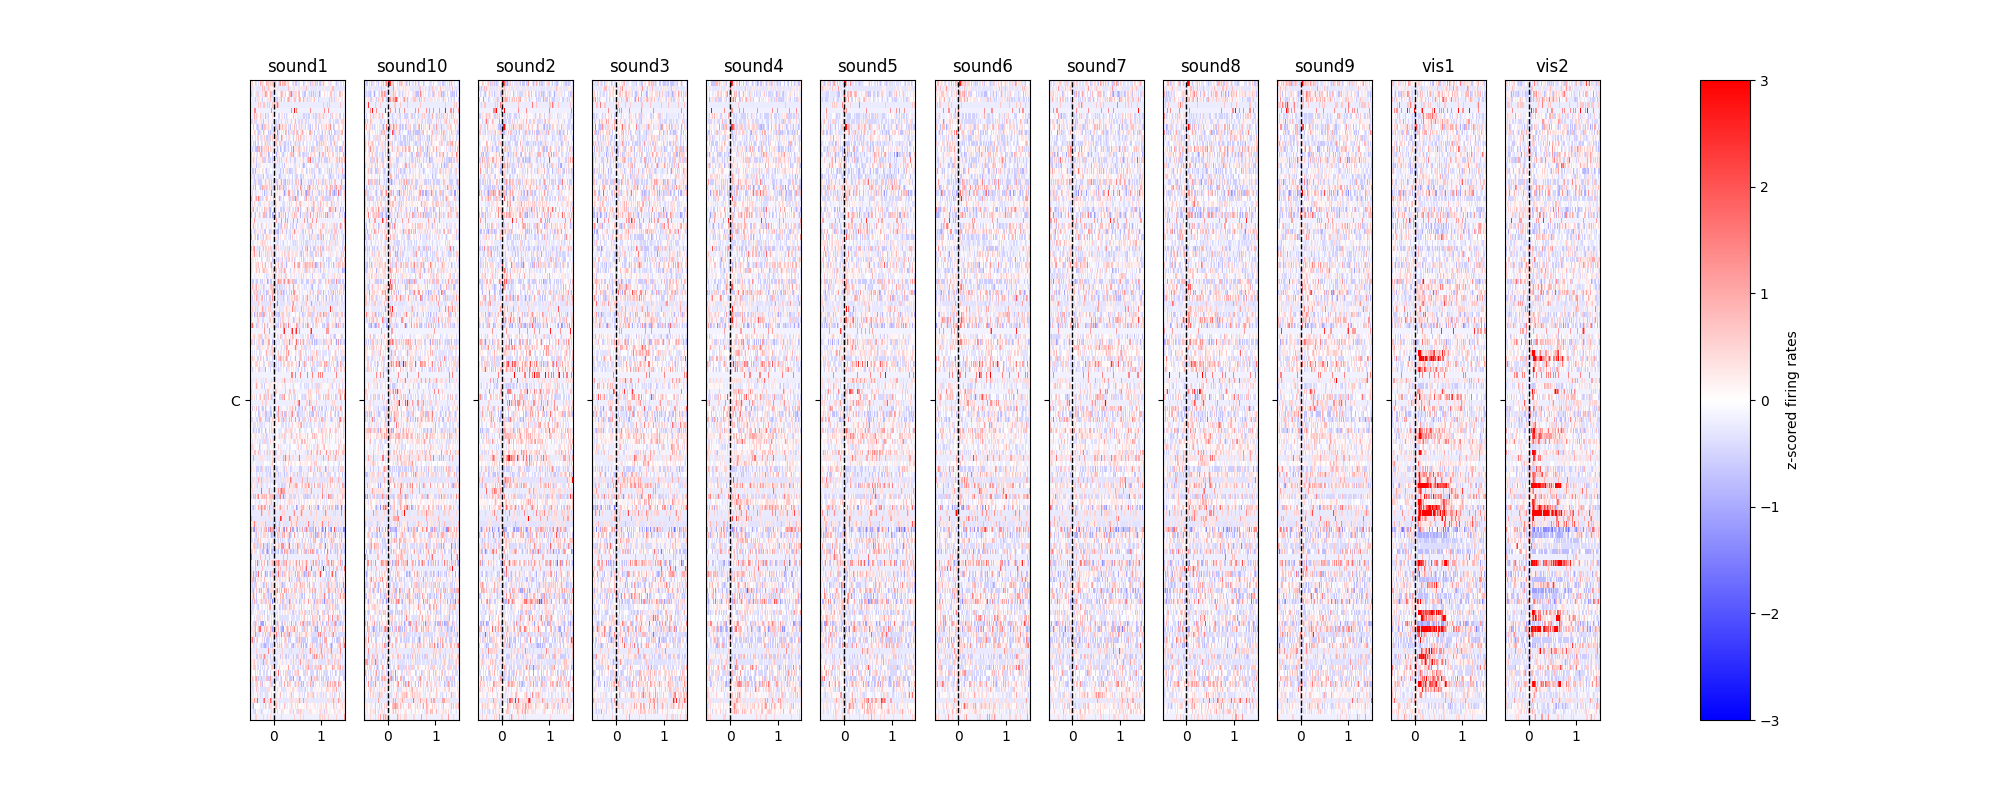

Text(0, 0.5, 'z-scored firing rates')

In [141]:
# plot heatmaps
# ordered by ascending channel number - top is tip of probe

fig,ax=plt.subplots(1,len(stimuli),figsize=(20,8))
for xx in range(0,len(stimuli)): 
    im = ax[xx].imshow(unit_frs_by_stim[:,:,xx],aspect='auto',vmin=-3,vmax=3,
                   cmap=plt.get_cmap('bwr'),interpolation='none',
                   extent=(-time_before_flash,trial_duration-time_before_flash,
                           0,unit_frs_by_stim.shape[0]))
    
    ax[xx].axvline(0,color='k',linestyle='--',linewidth=1)
    ax[xx].set_title(stimuli[xx])
    ax[xx].set_xlim(-0.5,1.5)
    ax[xx].hlines(unit_frs_by_stim.shape[0]-probe_borders,xmin=-0.5,xmax=1.5,
                   color='k',linewidth=1)
    ax[xx].set_yticks(unit_frs_by_stim.shape[0]-midpoints)
    ax[xx].set_yticklabels(probe_labels)
    if xx>0:
        ax[xx].set_yticklabels([])

# this adjusts the other plots to make space for the colorbar
fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.3) 
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('z-scored firing rates')


In [147]:
# significantly affected units

pre_window=[-0.2,-0.1]
stim_window=[0.00,0.1]

unit_stim_pvals=np.zeros((len(session.good_units),len(session.trials.trialStimID.unique())))
unit_stim_pvals[:]=np.nan

stim_list=np.sort(session.trials.trialStimID.unique())

# loop over units
for u_count, (uid, unit) in enumerate(session.good_units.iterrows()):

    # loop over stimuli
    for ss,stim in enumerate(stim_list):
        
#         stim_list.append(stim)
        # test if significantly affected (100ms baseline vs. 100ms stimulus)
        stim_trials=session.trials.query('trialStimID == @stim').index
        pre_trial_da=session.trial_da.sel(trials=stim_trials, unit_id=uid,
                                          time=slice(pre_window[0],pre_window[1])).mean(dim='time')
        stim_trial_da=session.trial_da.sel(trials=stim_trials, unit_id=uid,
                                           time=slice(stim_window[0],stim_window[1])).mean(dim='time')
        if np.sum(stim_trial_da-pre_trial_da)!=0:
            h,p=st.wilcoxon(pre_trial_da,stim_trial_da,zero_method='wilcox')
        else:
            p=1
        
        unit_stim_pvals[u_count,ss]=p
        
# find N units affected by any sound stimulus vs. any vis stimulus (that's the denominator)

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there ar

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there ar

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn(

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Anaconda3\envs\allensdk_38_new\lib\site-packa

In [148]:
unit_stim_pvals

array([[3.24908411e-01, 4.73534542e-01, 1.11412562e-04, ...,
        6.60213913e-04, 5.45117055e-02, 7.32456947e-01],
       [3.91172523e-01, 6.44085407e-01, 1.10828117e-01, ...,
        7.05456986e-01, 4.04794561e-02, 7.49805073e-01],
       [6.47401437e-01, 6.32457904e-02, 6.19695562e-02, ...,
        1.91533996e-01, 6.89177490e-02, 7.65896207e-01],
       ...,
       [2.66027272e-01, 4.34397236e-01, 2.71135472e-01, ...,
        7.11428654e-01, 2.44861255e-01, 2.67782384e-01],
       [3.54112309e-02, 9.81071478e-01, 8.55148719e-01, ...,
        2.09044205e-01, 2.52340156e-01, 4.57560224e-01],
       [2.76302917e-01, 6.54720846e-01, 8.32645167e-02, ...,
        1.79712495e-01, 4.57614067e-01, 1.00000000e+00]])

In [149]:
np.sum(unit_stim_pvals<0.01,axis=0)

array([ 6,  1,  8, 12,  1, 12, 16,  9,  1, 13,  6, 24, 25])

In [150]:
stim_list

array(['catch', 'sound1', 'sound10', 'sound2', 'sound3', 'sound4',
       'sound5', 'sound6', 'sound7', 'sound8', 'sound9', 'vis1', 'vis2'],
      dtype=object)

In [151]:
np.sort(session.trials.trialStimID.unique())

array(['catch', 'sound1', 'sound10', 'sound2', 'sound3', 'sound4',
       'sound5', 'sound6', 'sound7', 'sound8', 'sound9', 'vis1', 'vis2'],
      dtype=object)